# Finding a New Pet Store Location in St. Paul, MN

## Introduction / Business Problem

In 2019, US residents are estimated to spend [more than $75 billion](https://www.americanpetproducts.org/press_industrytrends.asp) for their pets. With more than 40% of it being spent on food, pet store is a lucrative business to get into. 

Our friend, John Doe, wants to open a new pet store in St. Paul, MN area, and has asked me to help finding a location for it. Cost of doing business in a metropolis city like St. Paul can be stratospheric, so location needs to be analyzed carefully. The insight will provide a good understanding on the target market and reduce risk of opening a location in the wrong side of the city. 

### Target Audience

John Doe will be my target audience for this project. The objective is to locate a neighborhood to open his new pet store in the city of St. Paul, MN. We will ensure the neighborhood that I pick is the most optimum one. 

## Data

### Zipcode data from [uszipcode](https://uszipcode.readthedocs.io/index.html#) Python package.  
It provides data for the **latitude and longitude** of all zipcode in the St. Paul, MN area along with the **median household income**.  

Please see the notebook section for more details on the cleaning up of the data.

In [2]:
import pandas as pd
import numpy as np
from uszipcode import SearchEngine
from geopy.geocoders import Nominatim 
import requests
import json 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium 

zipStPaul = pd.read_csv('zipStPaul.csv')
zipStPaul.head()

### Nominatim data 

I use Nominatim package to retrieve the latitude and longitude of St. Paul, MN

In [11]:
address = 'Saint Paul, MN'

geolocator = Nominatim(user_agent="spaul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of St. Paul using latitude and longitude values
map_stPaul = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, zipcode, medincome in zip(zipStPaul['latitude'], zipStPaul['longitude'], zipStPaul['zipcode'],zipStPaul['med_income']):
    label = 'zipcode: {}, median income: {}'.format(zipcode, medincome)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stPaul)  
    
map_stPaul

### FourSquare data from FourSquare [Places API](https://developer.foursquare.com/docs/api). 

I will utilize the explore function to get venue recommendations and zone in on the pet related categories (e.g. pet store, dog run, veterinarians). 

Please see the notebook section for more details on the cleaning up of the data.

In [12]:
stpaul_venues = pd.read_csv('stpaul_venues.csv')
stpaul_venues.head()

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Saint Paul,55101,44.95,-93.09,Keys Cafe & Bakery,44.951052,-93.094492,55101,Breakfast Spot
1,Saint Paul,55101,44.95,-93.09,"Black Dog, Lowertown",44.949231,-93.084219,55101,Café
2,Saint Paul,55101,44.95,-93.09,InterContinental St. Paul Riverfront,44.944410,-93.092557,55101,Hotel
3,Saint Paul,55101,44.95,-93.09,Black Sheep Pizza,44.951277,-93.094532,55101,Pizza Place
4,Saint Paul,55101,44.95,-93.09,Lunds & Byerlys,44.951551,-93.095062,55101,Supermarket


For specific pet related categories, we subset the data for these three category of interests:
- Dog Run
- Pet Store
- Veterinarian

In [13]:
# listing all the category of interest:
catInt = ['Dog Run','Pet Store','Veterinarian']
# subsetting the data
justpetfoursquare= stpaul_venues[stpaul_venues['Venue Category'].isin(catInt)]
# resetting the index:
justpetfoursquare = justpetfoursquare.reset_index(drop=True)
justpetfoursquare

,Neighborhood,Zipcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Zipcode,Venue Category
0,Saint Paul,55101,44.95,-93.09,Lowertown Dog Park,44.951180,-93.085508,55101,Dog Run
1,Saint Paul,55102,44.93,-93.12,High Bridge Dog Park,44.935525,-93.106320,55102,Dog Run
2,Roseville,55113,45.01,-93.16,Chuck & Don's Pet Food Outlet,45.024081,-93.169918,55113,Pet Store
3,Saint Paul,55114,44.97,-93.20,Twin Cities Reptiles,44.963767,-93.196522,55114,Pet Store
4,Saint Paul,55116,44.91,-93.17,Petco,44.918520,-93.196697,55116,Pet Store
5,Saint Paul,55116,44.91,-93.17,Chuck & Don's Pet Food Outlet,44.916832,-93.189630,55116,Pet Store
6,Maplewood,55117,45.00,-93.10,Como Park Animal Hospital,44.971809,-93.125984,55117,Veterinarian
7,Saint Paul,55119,44.94,-93.01,Battle Creek Dog Park,44.939410,-93.001641,55119,Dog Run
8,Saint Paul,55130,44.97,-93.09,Arlington Arkwright Dog Park,44.982032,-93.083346,55130,Dog Run


There are only 9 values and there should be more. So, I will augment the values from FourSquare API with values from **yelp API**.

### [Yelp Fusion API](https://www.yelp.com/developers/documentation/v3)

This dataset is used to augment the lack of pet related data in the FourSquare API.

Please see the notebook for details on the cleaning up.

In [15]:
petstpaul_venues = pd.read_csv('petstpaul_venues.csv')
petstpaul_venues.head()

,zip_code,Zipcode Latitude,Zipcode Longitude,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
0,55101,44.95,-93.09,Lofty Dogs,55101,44.949890,-93.086370,Dog Walkers
1,55101,44.95,-93.09,Wags Professional Pet Services,55101,44.948967,-93.084534,Dog Walkers
2,55101,44.95,-93.09,Pomeroy's Animal Hospital & Clinic,55101,44.950760,-93.091043,Veterinarians
3,55101,44.95,-93.09,Urban Animal Kingdom,55101,44.945536,-93.091914,Dog Walkers
4,55101,44.95,-93.09,Aska Pet Spa & Boutique,55101,44.950398,-93.090086,Pet Groomers


## Methodology

### Combining the dataset from FourSquare and Yelp API

Please see the notebook for the details on how I combine the two datasets. 

In [16]:
combined_df = pd.read_csv('combined_df.csv')
combined_df.head()

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
0,CHS Field,55101,44.950619,-93.084789,Baseball Stadium
1,Lunds & Byerlys,55101,44.951551,-93.095062,Supermarket
2,Lowertown Wine & Spirits,55101,44.948822,-93.085751,Liquor Store
3,Salty Tart,55101,44.950196,-93.085310,Bakery
4,Legacy Chocolates,55101,44.946779,-93.090173,Dessert Shop


### Reshaping the data for k-Nearest-Neighbor classification method

#### Tally up all the `Venue Category` based on the `Venue Zipcode`

In [17]:
# one hot encoding
stpaul_onehot = pd.get_dummies(combined_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stpaul_onehot['Zipcode'] = combined_df['Venue Zipcode'] 

# move neighborhood column to the first column
fixed_columns = [stpaul_onehot.columns[-1]] + list(stpaul_onehot.columns[:-1])
stpaul_onehot = stpaul_onehot[fixed_columns]

stpaul_onehot.head()

,Zipcode,ATM,African Restaurant,American Restaurant,Animal Shelters,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Veterinarians,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,55101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by `Zipcode` and by taking the mean of the frequency of occurrence of each category

In [18]:
stpaul_grouped = stpaul_onehot.groupby('Zipcode').mean().reset_index()
stpaul_grouped.head()

,Zipcode,ATM,African Restaurant,American Restaurant,Animal Shelters,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Veterinarians,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,55101,0.0,0.000000,0.021739,0.000000,0.0,0.000000,0.043478,0.0000,0.0,...,0.000000,0.021739,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,55102,0.0,0.012500,0.062500,0.000000,0.0,0.000000,0.000000,0.0125,0.0,...,0.000000,0.037500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,55103,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.0000,0.0,...,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.000000,0.000000,0.058824,0.117647
3,55104,0.0,0.021739,0.000000,0.021739,0.0,0.000000,0.021739,0.0000,0.0,...,0.021739,0.021739,0.0,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,55105,0.0,0.000000,0.014085,0.000000,0.0,0.028169,0.028169,0.0000,0.0,...,0.000000,0.028169,0.0,0.000000,0.014085,0.014085,0.014085,0.014085,0.000000,0.000000


#### Sort the data and show the top 10 most common venues in the zipcode of interests

In [19]:
# from previous work, define the function to get 
# the most common venues:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zipcode'] = stpaul_grouped['Zipcode']

for ind in np.arange(stpaul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stpaul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,Dog Walkers,Bar,Pizza Place,Liquor Store,New American Restaurant,Bakery,Coffee Shop,Theater,Asian Restaurant,Brewery
1,55102,Bar,American Restaurant,Italian Restaurant,Café,Park,Veterinarians,Brewery,French Restaurant,Theater,History Museum
2,55103,Zoo Exhibit,Vietnamese Restaurant,Garden,Lake,Zoo,Farmers Market,Asian Restaurant,Gym / Fitness Center,Mexican Restaurant,Noodle House
3,55104,Pet Sitting,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Breakfast Spot,Pizza Place,Rock Club,Soccer Stadium,Dessert Shop,Brewery
4,55105,Coffee Shop,Pizza Place,Liquor Store,Bakery,Pub,Asian Restaurant,Bookstore,Sporting Goods Shop,Ice Cream Shop,Restaurant


### Determining `k` for the machine learning method

Start by running multiple `k` values to find the optimal number of clusters for this particular dataset: 

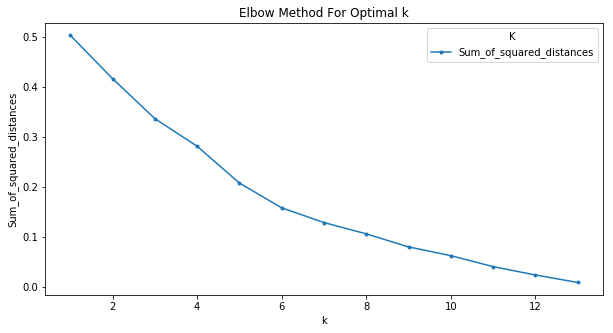

In [21]:
stpaul_grouped_clustering = stpaul_grouped.drop('Zipcode', 1)

Sum_of_squared_distances = []
K = range(1, 14)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(stpaul_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_) 

# plot the K
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
optimal_k.plot(kind = 'line', figsize = (10, 5), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Using the elbow method, the best K value seems to be 6 for our datasets.  

### Running the k-Nearest Neighbor classification

In [22]:
# set number of clusters
kclusters = 6

stpaul_grouped_clustering = stpaul_grouped.drop('Zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stpaul_grouped_clustering)

In [24]:
neighborhoods_venues_sorted['Zipcode']=neighborhoods_venues_sorted['Zipcode'].astype(int)
stpaul_merged = zipStPaul
stpaul_merged['zipcode']=stpaul_merged['zipcode'].astype(int)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge zipStPaul with neighborhoods_venues to add latitude/longitude for each neighborhood
stpaul_merged = stpaul_merged.join(neighborhoods_venues_sorted.set_index('Zipcode'), on='zipcode')

stpaul_merged.head() 

,zipcode,med_income,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,40300,44.95,-93.09,2,Dog Walkers,Bar,Pizza Place,Liquor Store,New American Restaurant,Bakery,Coffee Shop,Theater,Asian Restaurant,Brewery
1,55102,46255,44.93,-93.12,2,Bar,American Restaurant,Italian Restaurant,Café,Park,Veterinarians,Brewery,French Restaurant,Theater,History Museum
2,55103,28899,44.97,-93.13,1,Zoo Exhibit,Vietnamese Restaurant,Garden,Lake,Zoo,Farmers Market,Asian Restaurant,Gym / Fitness Center,Mexican Restaurant,Noodle House
3,55104,44629,44.96,-93.17,2,Pet Sitting,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Breakfast Spot,Pizza Place,Rock Club,Soccer Stadium,Dessert Shop,Brewery
4,55105,76472,44.93,-93.16,2,Coffee Shop,Pizza Place,Liquor Store,Bakery,Pub,Asian Restaurant,Bookstore,Sporting Goods Shop,Ice Cream Shop,Restaurant


### Visualizing the clusters

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stpaul_merged['latitude'], stpaul_merged['longitude'], stpaul_merged['zipcode'], stpaul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results

### Clusters Inspections

For the results section, I examine each cluster and extract features that distinguish each cluster.

#### Cluster 1

In [27]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 0, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,55106,42686,Mexican Restaurant,Chinese Restaurant,Pizza Place,Park,Bar,Veterinarians,Pet Stores,Brewery,Fast Food Restaurant,Butcher
11,55117,44040,Veterinarians,Fast Food Restaurant,Gym / Fitness Center,American Restaurant,Grocery Store,Sandwich Place,Video Store,Chinese Restaurant,Bar,Dessert Shop
12,55119,56275,Fast Food Restaurant,Video Store,Pizza Place,Coffee Shop,Chinese Restaurant,Burger Joint,Veterinarians,Miscellaneous Shop,Mobile Phone Shop,Shoe Store


`Cluster 1` has Veterinarians as part of their top 10 most common categories. It can be categorized as a potential spot for a new pet store location. The median income is in the $40-50k, which is in the upper middle value in our zipcode dataset. 

#### Cluster 2

In [28]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 1, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,55103,28899,Zoo Exhibit,Vietnamese Restaurant,Garden,Lake,Zoo,Farmers Market,Asian Restaurant,Gym / Fitness Center,Mexican Restaurant,Noodle House


``Cluster 2`` is located in 55103 zipcode, which can be categorized as the [North End](https://www.unitedstateszipcodes.org/55103) neighborhood. It does not seem to be a good place to open a new pet store, with low median income and no mention of pet categories in the top 10 most common venue.

#### Cluster 3

In [29]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 2, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55101,40300,Dog Walkers,Bar,Pizza Place,Liquor Store,New American Restaurant,Bakery,Coffee Shop,Theater,Asian Restaurant,Brewery
1,55102,46255,Bar,American Restaurant,Italian Restaurant,Café,Park,Veterinarians,Brewery,French Restaurant,Theater,History Museum
3,55104,44629,Pet Sitting,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Breakfast Spot,Pizza Place,Rock Club,Soccer Stadium,Dessert Shop,Brewery
4,55105,76472,Coffee Shop,Pizza Place,Liquor Store,Bakery,Pub,Asian Restaurant,Bookstore,Sporting Goods Shop,Ice Cream Shop,Restaurant
7,55108,56994,Coffee Shop,Park,American Restaurant,Snack Place,Veterinarians,Event Space,Breakfast Spot,Café,Campground,Exhibit
8,55113,61113,Veterinarians,Chinese Restaurant,Pizza Place,Coffee Shop,Pet Stores,Sandwich Place,American Restaurant,Shoe Store,Pub,Music Store
10,55116,61142,Coffee Shop,American Restaurant,Park,Scenic Lookout,Veterinarians,Liquor Store,Mexican Restaurant,Trail,Pizza Place,Pet Stores


`Cluster 3` has Dog Walkers, Veterinarians, Pet Sitting, and Pet Stores as part of their top 10 most common categories. It is more promising than `Cluster 1` because of the higher median income as well.  

From the list, I can recommend opening up a new pet store from **55105** zip code, which is located in the [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/). It has a high median income and there is no mention of pet store in the top 10 most common venues in the area. 

The second place that I would recommend is the **55108** zip code, which is located near the [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/). It has a slightly lower median income, but there are already veterinarians as the top 10 most common venues in this neighborhood.

The third place that I would recommend is the **55104** zip code, which is located in the [Hamline-Midway neighborhood](https://www.unitedstateszipcodes.org/55104/). It has pet sitting as the most common venue, with a lower median income in the area. More research needs to be done if our client pick this area as their preferred location.

#### Cluster 4

In [30]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 3, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,55107,44913,Mexican Restaurant,Brewery,Pet Training,Restaurant,Harbor / Marina,Burrito Place,Taco Place,Automotive Shop,Scenic Lookout,Pet Groomers


``Cluster 4`` is located in 55107 zipcode, which can be categorized as the [West End](https://www.unitedstateszipcodes.org/55107) neighborhood. It does not seem to be a good place to open a new pet store, with having both Pet Training and Pet Groomers already in the top 10 most common venue. Pet Groomers usually sell similar items that are the same as Pet Stores on top of their grooming business.

#### Cluster 5

In [31]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 4, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,55130,30092,Liquor Store,American Restaurant,Pet Sitting,History Museum,Gastropub,Dog Run,Pet Training,Athletics & Sports,Italian Restaurant,Restaurant


``Cluster 5`` is located in 55130 zipcode, which can be categorized as the [Payne-Phalen](https://www.unitedstateszipcodes.org/55107) neighborhood. It does not seem to be a good place to open a new pet store, with lower median income value than `Cluster 3` and having Pet Sitting, Dog Run, and Pet Training already in the top 10 most common venue. They signal a saturated neighborhood to open a Pet Store.

#### Cluster 6

In [32]:
stpaul_merged.loc[stpaul_merged['Cluster Labels'] == 5, stpaul_merged.columns[
    [0,1] + list(range(5, stpaul_merged.shape[1]))]]

,zipcode,med_income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,55114,38861,Coffee Shop,Brewery,Record Shop,Bar,Italian Restaurant,Gym,Middle Eastern Restaurant,Music Store,Organic Grocery,Pet Services


``Cluster 6`` is located in 55114 zipcode, which can be categorized as the [St. Anthony](https://www.unitedstateszipcodes.org/55114) neighborhood. It does not seem to be a good place to open a new pet store, with lower median income value than `Cluster 3` and having Pet Services already in the top 10 most common venue. They signal a neighborhood that might not be able to sustain a Pet Store in the area.

## Discussions

From the Results sections, I picked **55105, 55108, and 55104** as the three most promizing zip codes to open a new pet store.

In order to ascertain this finding, I will look at the data more closely on each of the zip code starting with the **55105**, [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/). 

In [34]:
catInt2 = ['Dog Walkers','Veterinarians','Pet Groomers','Pet Sitting',
           'Pet Stores','Pet Training','Pet Services','Animal Shelters']

zipcode55105 = combined_df[combined_df['Venue Zipcode']==55105]
zipcode55105[zipcode55105['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
246,Bubbly Paws,55105,44.940280,-93.140160,Pet Groomers
248,Dog Days Daycare & Boarding - Grand Ave,55105,44.939774,-93.174835,Pet Training
249,Grand Avenue Veterinary Center,55105,44.939693,-93.148247,Veterinarians
250,Grand Groomers,55105,44.939659,-93.140472,Pet Groomers
251,St. Paul Pet Supply,55105,44.939978,-93.174938,Pet Stores
259,Animal Medical Clinic,55105,44.934563,-93.166825,Veterinarians


The competitors for this area is only St. Paul Pet Supply. Moreover, there are already a lot of services for pet in the area. It is also the highest median income location of the three (~\\$76,000). It is very promising to open up a pet store in this area. However, grocery store and supermarket sell pet supplies as well. So, let's take a look on whether there are any in this zip code area:

In [35]:
zipcode55105[zipcode55105['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
200,Trader Joe's,55105,44.926666,-93.146004,Grocery Store
217,Kowalski's Market,55105,44.940270,-93.153639,Grocery Store


There are two grocery stores that do sell pet related items in their shelves. So, ensuring that the type of items sold in the pet stores are different enough than the ones sold in grocery stores can be a good strategy to take if John Doe want to move forward with this location as the place where he wants to open up his new pet store. 

Moving forward, let us look at the data from the [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/) in the 55108 zip code location.

In [36]:
zipcode55108 = combined_df[combined_df['Venue Zipcode']==55108]
zipcode55108[zipcode55108['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
332,Raptor Center,55108,44.982871,-93.181639,Veterinarians
333,University of Minnesota Veterinary Medical Center,55108,44.982202,-93.181925,Veterinarians
338,Animal Humane Society - St. Paul,55108,44.974723,-93.154704,Animal Shelters


This location is promising. There are two veterinarians and an adoption center in the Falcon Heights, without a pet store in sight. The grocery store can be a deterrent for John Doe to open up a new pet store, so we will look into the data for it.

In [37]:
zipcode55108[zipcode55108['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
310,Tim & Tom's Speedy Market,55108,44.981728,-93.195084,Grocery Store


[Tim & Tom's Speedy Market](https://timandtomsspeedymarket.com/) is a specialty grocery store that do not sell pet related items. It has a lower median income (~\\$56,000) compared to the Macalester neighborhood (~\\$76,000). So, this is a very promising location for opening up a new pet store for John Doe.  

Lastly, we look at the [Hamline-Midway neighborhood](https://www.unitedstateszipcodes.org/55104/) in the 55104 zip code. 

In [38]:
zipcode55104 = combined_df[combined_df['Venue Zipcode']==55104]
zipcode55104[zipcode55104['Venue Category'].isin(catInt + list(set(catInt2) - set(catInt)))]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category
158,Urban Tails Waggin,55104,44.947160,-93.126560,Dog Walkers
159,St. Paws Dog Daycare & Boarding,55104,44.956924,-93.181053,Pet Sitting
160,Midway Animal Hospital,55104,44.963242,-93.167572,Veterinarians
184,Grand Paws Professional Dog & Cat Grooming,55104,44.959050,-93.156620,Pet Sitting
185,Feline Rescue,55104,44.959064,-93.177597,Animal Shelters
186,VCA Feist Animal Hospital,55104,44.948252,-93.160780,Pet Sitting
187,Pawsitivity Service Dogs,55104,44.947284,-93.151974,Pet Services


Similar to the [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/) (55105) zip code, there are no pet store, but a lot of pet services in this area. It has a lower median income than the other neighborhood (~\\$44,000), but it is still a promising location for a new pet store. In terms of grocery store and super market, John Doe would like to know whether there is any in the area.

In [39]:
zipcode55104[zipcode55104['Venue Category'].isin(['Grocery Store','Supermarket'])]

,Venue,Venue Zipcode,Venue Latitude,Venue Longitude,Venue Category


No grocery store in the area. Keep in mind that this location has a lower median income than the other two zip codes, this is a very promising location to open up a pet store. 

## Conclusion

Based on the k-Nearest-Neighbor algorithm, I recommend John Doe to open up a new pet store in three different zip code in the St. Paul, MN region. First is the [Macalester-Groveland neighborhood](https://www.unitedstateszipcodes.org/55105/) (55105). They have high median income with many pet services and only one other pet store in the area. In order to succeed, John Doe needs to make sure that the type of items sold in the pet stores are different enough than the ones sold in grocery stores and the other pet store. Second is the [Falcon Heights area](https://www.unitedstateszipcodes.org/55108/) (55108). They do not have a pet store, but veterinarian hospitals and animal shelters are in the area. Third is the [Hamline-Midway neighborhood](https://www.unitedstateszipcodes.org/55104/) (55104). They have a lot of pet services, but with lower median household income than the other two zip codes. 